# Financial Statement Classification

## Introduction

This project aims to classify tables extracted from financial statements into categories: Income Statements, Balance Sheets, Cash Flows, Notes, and Others. The classification was achieved using various machine learning models, with a focus on model performance and accuracy.

## Imports

In [381]:
# Import libraries
# file processing
import os
from bs4 import BeautifulSoup

# data processing
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer

# machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report ,confusion_matrix, f1_score, precision_score, recall_score
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ignore warnings
import warnings
warnings.filterwarnings('ignore')


## Data Extraction and preprocessing

### Data Extraction

Text was extracted from HTML files using BeautifulSoup. This library is effective for parsing HTML and XML documents and extracting data from them.

In [382]:
def extract_text_from_html(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
    soup = BeautifulSoup(content, 'html.parser')
    text = soup.get_text(separator=' ', strip=True)
    return text

def process_specific_directories_to_dataframe(base_dir, folders):
    data = []
    
    # Iterate through each specified folder
    for folder in folders:
        folder_path = os.path.join(base_dir, folder)
        if os.path.isdir(folder_path):
            # Iterate through each HTML file in the folder
            for file_name in os.listdir(folder_path):
                if file_name.endswith('.html'):
                    file_path = os.path.join(folder_path, file_name)
                    extracted_text = extract_text_from_html(file_path)
                    data.append({'text': extracted_text, 'category': folder})
    
    # Create a DataFrame
    df = pd.DataFrame(data)
    return df

In [383]:
base_dir = 'C:/Users/Admin/Downloads/data_finclav/data'
folders = ['Balance Sheets', 'Cash Flow', 'Income Statement', 'Notes', 'Others']
df = process_specific_directories_to_dataframe(base_dir, folders)

# Display the DataFrame
df.head()

,text,category
0,(7 in lacs) (7 in lacs) _1_ Standalone Consoli...,Balance Sheets
1,Consolidated Standalone Particulars As at As a...,Balance Sheets
2,Standalone Consolidated Audited Audited Partic...,Balance Sheets
3,GUJARAT NARMADA VALLEY FERTILIZERS & CHEMICALS...,Balance Sheets
4,Standalone Consolidated As at As at As at As a...,Balance Sheets


In [384]:
df.to_csv('data_extract.csv')

In [385]:
df.shape

(2525, 2)

In [386]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2525 entries, 0 to 2524
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      2525 non-null   object
 1   category  2525 non-null   object
dtypes: object(2)
memory usage: 39.6+ KB


###  Preprocessing

Preprocessing steps included removing unwanted characters, digits, punctuation, extra spaces, converting text to lowercase, and stemming. These steps ensure that the text data is clean and standardized, making it suitable for machine learning models.


In [387]:
df.isnull().sum()

text        0
category    0
dtype: int64

In [388]:
df.duplicated().sum()

21

In [389]:
df = df.drop_duplicates(keep='first')

In [390]:
df.shape

(2504, 2)

In [391]:
df["text"][0]

'(7 in lacs) (7 in lacs) _1_ Standalone Consolidated Sr. No. Particulars As at 31st March 2018 As at 31st March 2017 As at 31st March 2018 As at 31st March 2017 A Assets 1) Non-Current Assets (a) Property, Plant and Equipment 10,723.96 9,281.23 10,723.96 9,281.23 (b) Capital work in progress 607.46 - 607.46 - (c) Intangible assets 17.44 18.71 17.44 18.71 (d) Financial assets (i) Non-current investments 150.00 150.00 63.42 24.69 (ii) Loans - - - - (iii) Other financial assets 197.66 130.62 197.66 130.62 (e) Other non-current assets - - - - Total Non-Current Assets (A) 11,696.52 9,580.56 11,609.94 9,455.25 2) Current Assets (a) Inventories 8,002.02 13,925.10 8,002.02 13,925.10 (b) Financial assets (i) Trade Receivables 18,541.75 13,671.01 18,541.75 13,671.01 (ii) Cash and cash equivalents 2,883.82 177.11 2,883.82 177.11 (iii) Bank balances other than (ii) above 357.08 1,538.45 357.08 1,538.45 (ivj Loans 3.12 1.79 3.12 1.79 (v) Other Financial assets 220.19 1,035.36 220.19 1,035.36 (c) Ot

### Removing unwanted characters, Digits,Punctuations and extra spaces

- Unwanted characters, digits, and punctuation are removed to retain only the text data.
- Extra spaces are removed, and leading/trailing spaces are trimmed to ensure consistency.

In [392]:
df['clean_text'] = df['text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', ' ', x))
df['clean_text'] = df['clean_text'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())
df

,text,category,clean_text
0,(7 in lacs) (7 in lacs) _1_ Standalone Consoli...,Balance Sheets,in lacs in lacs Standalone Consolidated Sr No ...
1,Consolidated Standalone Particulars As at As a...,Balance Sheets,Consolidated Standalone Particulars As at As a...
2,Standalone Consolidated Audited Audited Partic...,Balance Sheets,Standalone Consolidated Audited Audited Partic...
3,GUJARAT NARMADA VALLEY FERTILIZERS & CHEMICALS...,Balance Sheets,GUJARAT NARMADA VALLEY FERTILIZERS CHEMICALS L...
4,Standalone Consolidated As at As at As at As a...,Balance Sheets,Standalone Consolidated As at As at As at As a...
...,...,...,...
2520,"1. Singhi & Co., 2. Chatterjee & Co., 3. V.K. ...",Others,Singhi Co Chatterjee Co V K Dhingra Co A K Sab...
2521,Singhi & Co. Chatterjee &Co. V.K. Dhingra & Co...,Others,Singhi Co Chatterjee Co V K Dhingra Co A K Sab...
2522,"r* • • *“•"" 1 1 i • • 1 1 1 STEEL AUTHORITY OF...",Others,r i STEEL AUTHORITY OF INDIA LIMITED CIN L DL ...
2523,"Particulars Quarter ended Year ended March 31,...",Others,Particulars Quarter ended Year ended March Aud...


### Converting Text to Lowercase

Text is converted to lowercase to maintain uniformity.

In [393]:
# Convert text to lowercase
df['clean_text'] = df['clean_text'].apply(lambda x: x.lower())
df

,text,category,clean_text
0,(7 in lacs) (7 in lacs) _1_ Standalone Consoli...,Balance Sheets,in lacs in lacs standalone consolidated sr no ...
1,Consolidated Standalone Particulars As at As a...,Balance Sheets,consolidated standalone particulars as at as a...
2,Standalone Consolidated Audited Audited Partic...,Balance Sheets,standalone consolidated audited audited partic...
3,GUJARAT NARMADA VALLEY FERTILIZERS & CHEMICALS...,Balance Sheets,gujarat narmada valley fertilizers chemicals l...
4,Standalone Consolidated As at As at As at As a...,Balance Sheets,standalone consolidated as at as at as at as a...
...,...,...,...
2520,"1. Singhi & Co., 2. Chatterjee & Co., 3. V.K. ...",Others,singhi co chatterjee co v k dhingra co a k sab...
2521,Singhi & Co. Chatterjee &Co. V.K. Dhingra & Co...,Others,singhi co chatterjee co v k dhingra co a k sab...
2522,"r* • • *“•"" 1 1 i • • 1 1 1 STEEL AUTHORITY OF...",Others,r i steel authority of india limited cin l dl ...
2523,"Particulars Quarter ended Year ended March 31,...",Others,particulars quarter ended year ended march aud...


In [394]:
df["clean_text"][0]

'in lacs in lacs standalone consolidated sr no particulars as at st march as at st march as at st march as at st march a assets non current assets a property plant and equipment b capital work in progress c intangible assets d financial assets i non current investments ii loans iii other financial assets e other non current assets total non current assets a current assets a inventories b financial assets i trade receivables ii cash and cash equivalents iii bank balances other than ii above ivj loans v other financial assets c other current assets total current assets b total assets a b b equity liabilities equity a equity share capital b other equity total equity a liabilities non current liabilities a financial liabilities i long term borrowings ii other non current financial liability bj long term provisions c deferred tax liabilities net total non current liabilities b current liabilities a financial liabilities i short term borrowings ii trade payables iii other current financial l

### Stemming

Words are reduced to their root form using stemming, which helps in standardizing the text data.

In [395]:
## Stemming
ps = PorterStemmer()

In [396]:
def stem(text):
  y = []
  for i in text.split():
    y.append(ps.stem(i))
  return " ".join(y)

In [397]:
df['clean_text'] = df['clean_text'].apply(stem)

In [398]:
df.clean_text[0]

'in lac in lac standalon consolid sr no particular as at st march as at st march as at st march as at st march a asset non current asset a properti plant and equip b capit work in progress c intang asset d financi asset i non current invest ii loan iii other financi asset e other non current asset total non current asset a current asset a inventori b financi asset i trade receiv ii cash and cash equival iii bank balanc other than ii abov ivj loan v other financi asset c other current asset total current asset b total asset a b b equiti liabil equiti a equiti share capit b other equiti total equiti a liabil non current liabil a financi liabil i long term borrow ii other non current financi liabil bj long term provis c defer tax liabil net total non current liabil b current liabil a financi liabil i short term borrow ii trade payabl iii other current financi liabil b other current liabil c short term provis d current tax liabil net total current liabil c total equiti and liabil a b c'

### Category column - distribution

In [399]:
df["category"].value_counts()

Others              1207
Notes                686
Income Statement     305
Balance Sheets       270
Cash Flow             36
Name: category, dtype: int64

In [400]:
#percentage distribution
print(round(df["category"].value_counts()/len(df)*100),2)

Others              48.0
Notes               27.0
Income Statement    12.0
Balance Sheets      11.0
Cash Flow            1.0
Name: category, dtype: float64 2


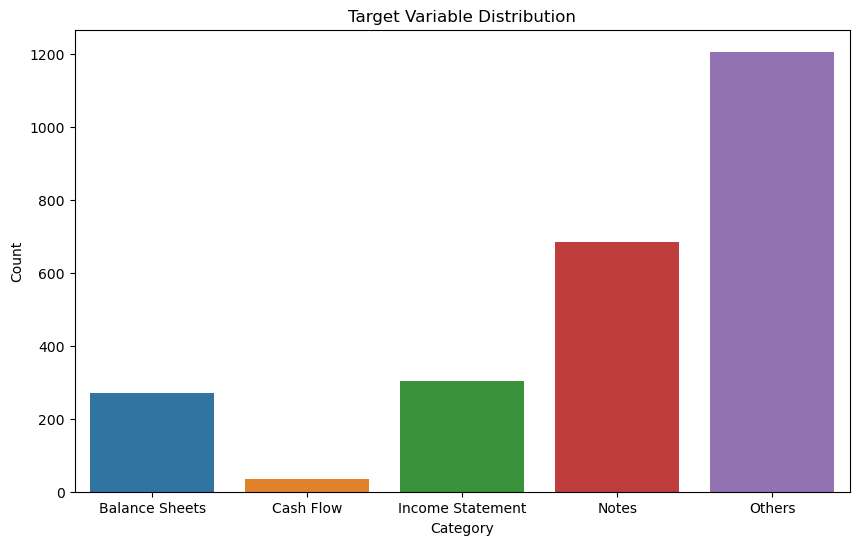

In [401]:
#plotting the target variable
plt.figure(figsize=(10,6))
sns.countplot(x='category', data=df)
plt.title('Target Variable Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.savefig("imbalanced.png")
plt.show()



### Encoding the target variable

The target variable (categories) is encoded into numerical values using LabelEncoder.

In [402]:
## encoding the target variable
encoder = LabelEncoder()
df['category'] = encoder.fit_transform(df['category'])
df

,text,category,clean_text
0,(7 in lacs) (7 in lacs) _1_ Standalone Consoli...,0,in lac in lac standalon consolid sr no particu...
1,Consolidated Standalone Particulars As at As a...,0,consolid standalon particular as at as at mar ...
2,Standalone Consolidated Audited Audited Partic...,0,standalon consolid audit audit particular as a...
3,GUJARAT NARMADA VALLEY FERTILIZERS & CHEMICALS...,0,gujarat narmada valley fertil chemic limit sta...
4,Standalone Consolidated As at As at As at As a...,0,standalon consolid as at as at as at as at par...
...,...,...,...
2520,"1. Singhi & Co., 2. Chatterjee & Co., 3. V.K. ...",4,singhi co chatterje co v k dhingra co a k saba...
2521,Singhi & Co. Chatterjee &Co. V.K. Dhingra & Co...,4,singhi co chatterje co v k dhingra co a k saba...
2522,"r* • • *“•"" 1 1 i • • 1 1 1 STEEL AUTHORITY OF...",4,r i steel author of india limit cin l dl go re...
2523,"Particulars Quarter ended Year ended March 31,...",4,particular quarter end year end march audit re...


## Model Training and evaluation

### Data splitting and vectorization

The dataset is split into training and testing sets. The text data is then transformed into numerical vectors using CountVectorizer.

In [403]:
x= df['clean_text']
y = df['category']
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=0)

In [404]:

cv = CountVectorizer(max_features=5000,stop_words='english')

In [405]:
x_train_cv = cv.fit_transform(x_train)
x_test_cv = cv.transform(x_test)


###  Balancing the target variable

In [406]:
smote = SMOTE(random_state=42)
x_train_cv_smote, y_train_smote = smote.fit_resample(x_train_cv, y_train)

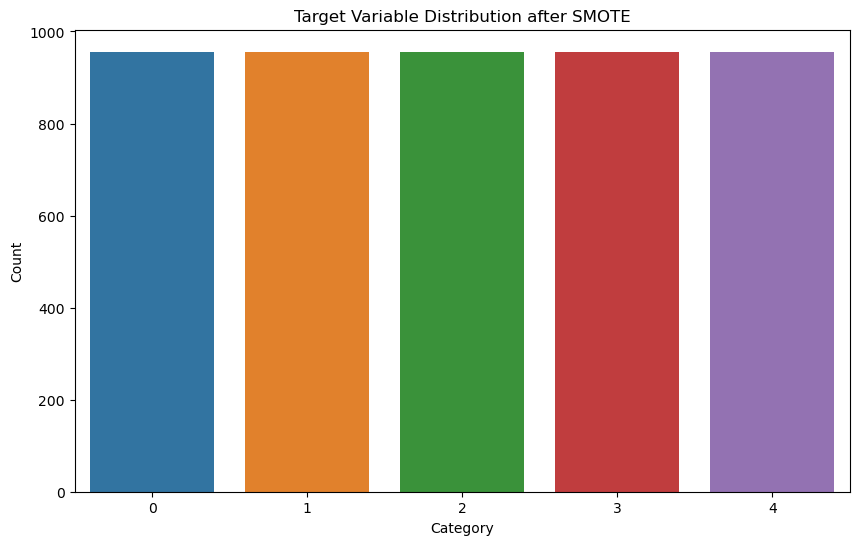

In [407]:
# plot the distribution of the target variable after SMOTE
plt.figure(figsize=(10,6))
sns.countplot(x=y_train_smote)
plt.title('Target Variable Distribution after SMOTE')
plt.xlabel('Category')
plt.ylabel('Count')
plt.savefig("balanced.png")
plt.show()



### Training and Evaluation Function

A function is created to train and evaluate the models, calculating accuracy, precision, recall, and F1 score.

In [375]:
def train_and_evaluate_model(model):
    model.fit(x_train_cv_smote, y_train_smote)
    y_pred = model.predict(x_test_cv)
    accuracy = round(accuracy_score(y_test, y_pred), 2)
    precision = round(precision_score(y_test, y_pred, average='weighted'), 2)
    recall = round(recall_score(y_test, y_pred, average='weighted'), 2)
    f1 = round(f1_score(y_test, y_pred, average='weighted'), 2)
    return accuracy, precision, recall, f1


### Models Used

- __Support Vector Machine (SVM)-__
SVM is effective in high-dimensional spaces and is often used for text classification.

- __Multinomial Naive Bayes-__
Naive Bayes classifiers are particularly suited for text classification tasks due to their simplicity and efficiency.

- __Random Forest-__
An ensemble method that builds multiple decision trees and merges them to get a more accurate and stable prediction.

- __Logistic Regression-__
A statistical model that in its basic form uses a logistic function to model a binary dependent variable.

- __XGBoost-__
An optimized gradient-boosting algorithm that is highly efficient and accurate.

- __Multilayer Perceptron (Neural Network)-__
A type of neural network that consists of multiple layers of nodes, each fully connected to the next layer. It is capable of capturing complex patterns in data.


In [376]:
# #Initialize models
models = {
    "Support Vector Machine (SVM)": SVC(kernel='linear', random_state=42),
    "Multinomial Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "XGBoost": XGBClassifier(verbosity=0, random_state=42),
    "Multilayer Perceptron (Neural Network)": MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=1000, random_state=42),
    "K-Nearest Neighbors (KNN)": KNeighborsClassifier(n_neighbors=5, algorithm='auto'),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}

### Model Comparison

The models were trained and evaluated, and their performance metrics were collected.

In [377]:
# List to store metrics
metrics_list = []

# Train and evaluate models
for name, model in models.items():
    accuracy, precision, recall, f1 = train_and_evaluate_model(model)
    print(f"{name} Accuracy:", accuracy)
    print(f"{name} Classification Report:\n", classification_report(y_test, model.predict(x_test_cv), target_names=encoder.classes_))
    print("confusion matrix:\n", confusion_matrix(y_test, model.predict(x_test_cv)))
    print("=" * 60)
    metrics_list.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })
    
# Convert metrics list to DataFrame
metrics_df = pd.DataFrame(metrics_list)
metrics_df.sort_values(by='Accuracy',ascending=False,inplace=True)

Support Vector Machine (SVM) Accuracy: 0.89
Support Vector Machine (SVM) Classification Report:
                   precision    recall  f1-score   support

  Balance Sheets       0.93      1.00      0.96        51
       Cash Flow       0.55      1.00      0.71         6
Income Statement       0.85      0.97      0.91        60
           Notes       0.81      0.89      0.85       133
          Others       0.95      0.84      0.89       251

        accuracy                           0.89       501
       macro avg       0.82      0.94      0.86       501
    weighted avg       0.90      0.89      0.89       501

confusion matrix:
 [[ 51   0   0   0   0]
 [  0   6   0   0   0]
 [  0   0  58   0   2]
 [  0   5   1 119   8]
 [  4   0   9  28 210]]
Multinomial Naive Bayes Accuracy: 0.82
Multinomial Naive Bayes Classification Report:
                   precision    recall  f1-score   support

  Balance Sheets       0.82      1.00      0.90        51
       Cash Flow       0.86      1.00  

In [378]:
metrics_df.reset_index(drop=True,inplace=True)
metrics_df

,Model,Accuracy,Precision,Recall,F1 Score
0,Random Forest,0.95,0.95,0.95,0.95
1,XGBoost,0.95,0.95,0.95,0.95
2,Logistic Regression,0.94,0.94,0.94,0.94
3,Multilayer Perceptron (Neural Network),0.91,0.92,0.91,0.91
4,Support Vector Machine (SVM),0.89,0.90,0.89,0.89
5,Decision Tree,0.88,0.88,0.88,0.88
6,K-Nearest Neighbors (KNN),0.86,0.89,0.86,0.87
7,Multinomial Naive Bayes,0.82,0.87,0.82,0.82


### Plotting the Results

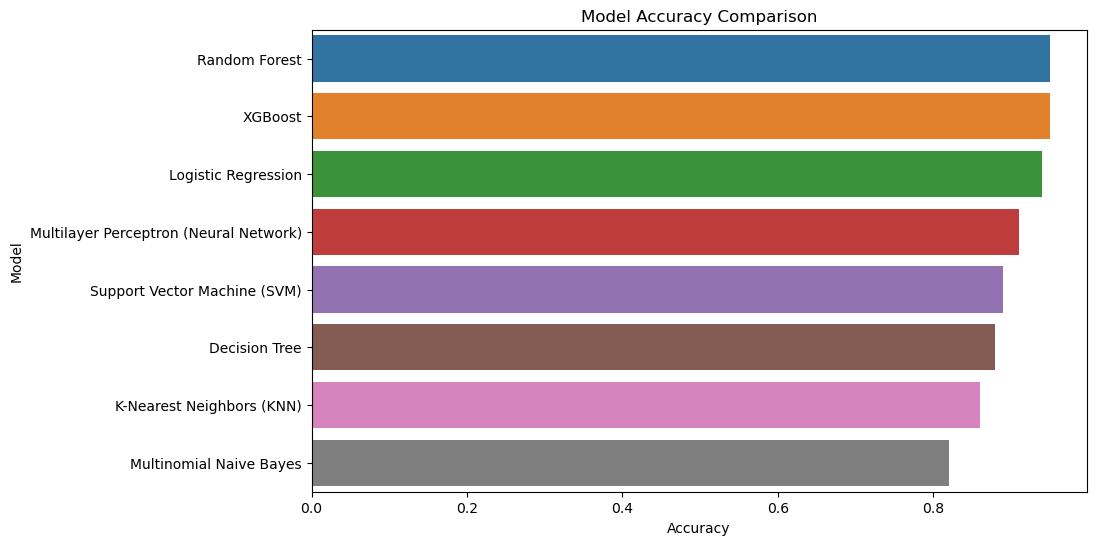

In [408]:
# Plot the accuracies
plt.figure(figsize=(10, 6))
sns.barplot(x='Accuracy', y='Model', data=metrics_df)
plt.title('Model Accuracy Comparison')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.savefig("model_comparison.png")
plt.show()

## Conclusion

Based on the evaluation metrics, the __Random Forest__  and __XGBoost__ models achieved the highest accuracy at 95%, followed closely by __Logistic Regression__  with an accuracy of 94%.


## Recommendations

Given the high accuracy and robust performance across multiple metrics, the __Random Forest model__ or __XGBoost model__ is recommended for deployment in the classification of financial statement tables. The model's ensemble nature makes it particularly suitable for handling diverse and complex datasets.

In [380]:
%store metrics_df

Stored 'metrics_df' (DataFrame)
